In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"


In [2]:
import torch
print("Visible GPUs:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0))
device = torch.device("cuda")   # this is physical GPU 7 now


Visible GPUs: 1
GPU name: GeForce RTX 2080 Ti


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

soap_saved = np.load("/home/ujjwal/26jan/SOAP_all_together.npy")   # (N, 324)

stride = 10   # change: 10, 50, 100 etc.
data_s = soap_saved[::stride, :]

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_s).astype(np.float32)

print("soap_saved:", soap_saved.shape, soap_saved.dtype)
print("data_s:", data_s.shape, data_s.dtype)
print("scaled:", scaled.shape, scaled.dtype)


soap_saved: (4640000, 324) float32
data_s: (464000, 324) float32
scaled: (464000, 324) float32


In [4]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, torch.from_numpy(scaled))  # stays on CPU
n_val = int(len(dataset) * 0.25)

train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val],
    generator=torch.Generator().manual_seed(0)
)

loader_train = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
loader_val   = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)

print("train batches:", len(loader_train), "val batches:", len(loader_val))
print("dtype check:", loader_train.dataset.dataset[0][0].dtype)


train batches: 10875 val batches: 3625
dtype check: torch.float32


In [5]:
import torch
from deeptime.decomposition.deep import TVAE, TVAEEncoder
from deeptime.util.torch import MLP

units = [324, 1024, 256, 2]

encoder = TVAEEncoder(units, nonlinearity=torch.nn.ELU, initial_batchnorm=False).to(device)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ELU, initial_batchnorm=True).to(device)

tae = TVAE(encoder, decoder, learning_rate=1e-4, device=device, beta=0.0001)

tae.fit(loader_train, n_epochs=25, validation_loader=loader_val)
tae_model = tae.fetch_model()

print("done")


done


In [6]:
import torch

save_path = "/home/ujjwal/26jan/tvae_model.pt"

# handle DataParallel or normal modules
enc = tae._encoder.module if hasattr(tae._encoder, "module") else tae._encoder
dec = tae._decoder.module if hasattr(tae._decoder, "module") else tae._decoder

checkpoint = {
    "encoder_state_dict": enc.state_dict(),
    "decoder_state_dict": dec.state_dict(),
    "units": units,
    "beta": tae._beta,
    "learning_rate": tae.learning_rate,
}

torch.save(checkpoint, save_path)
print("Model saved to:", save_path)

Model saved to: /home/ujjwal/26jan/tvae_model.pt


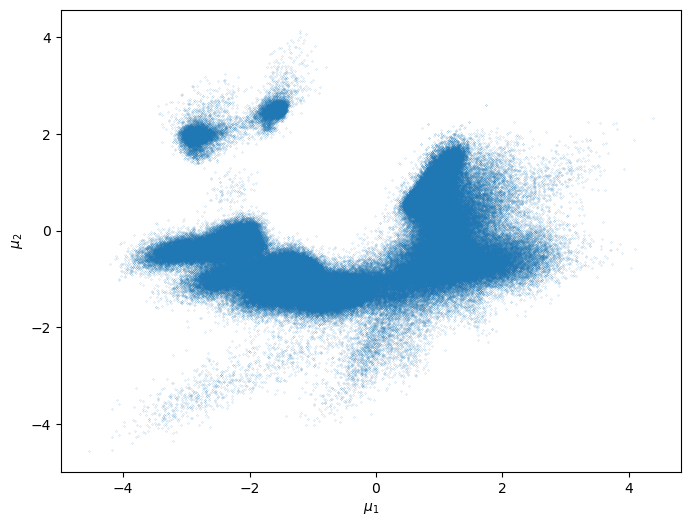

In [7]:
import numpy as np
import matplotlib.pyplot as plt

X = scaled.astype(np.float32, copy=False)

proj = tae_model.transform(X)          # (N, 2)

plt.figure(figsize=(8, 6))
plt.scatter(proj[:, 0], proj[:, 1], s=0.01)
plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")
plt.show()


In [8]:
import numpy as np

In [9]:
al2cu = np.load("/home/ujjwal/26jan/min0K_relaxed_Al2Cu_DL030.dump.npy")
test_proj_al2cu = tae_model.transform(scaler.transform(np.concatenate(al2cu)))
fcc = np.load("/home/ujjwal/26jan/min0K_relaxed_FCC_DL030.dump.npy")
test_proj_fcc = tae_model.transform(scaler.transform(np.concatenate(fcc)))
ni3p = np.load("/home/ujjwal/26jan/min0K_relaxed_Ni3P_DL030.dump.npy")
test_proj_ni3p = tae_model.transform(scaler.transform(np.concatenate(ni3p)))